In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tools
reload(tools)
from tools import *

In [5]:
source = "/home/walterms/mcmd/nn/data/unlbl/"
fnames = sorted([source+f for f in os.listdir(source)])
foutdir = "/home/walterms/mcmd/nn/data/pca/"
run = "nbrs_e3"

newnames = []
for f in fnames:
    if f.endswith(".log") or f.endswith("swp"): continue
    if f.startswith(source+"edge_3"): 
        newnames.append(f)
fnames = newnames

# Sort based on edge size
edges = []
for f in fnames:
    edg = float(f[len(source)+len("edge_3_"):])
    rh = 28**2 / (edg**2)
    edges.append([edg,rh])

idxs = np.argsort(edges,axis=0)
edges = np.array([edges[i] for i in idxs[:,0]])
fnames = [fnames[i] for i in idxs[:,0]]
fnames, edges = fnames[::6], edges[::6]
nfiles = len(fnames)

In [6]:
# FOR XTUD SETS
# Note, nProc = 10000, sweepEval = 100, nEquil = 0
source = "/home/walterms/mcmd/nn/data/train/"
fnames = [source+f for f in ["X","U","D","T"]]
foutdir = "/home/walterms/mcmd/nn/data/pca/"
run = "nbrs_xtud"

nfiles = 4
nrod = 28**2
edges = np.array([[6.324, nrod/(6.324**2)] for _ in range(nfiles)])

In [7]:
edges

array([[ 6.324     , 19.60344236],
       [ 6.324     , 19.60344236],
       [ 6.324     , 19.60344236],
       [ 6.324     , 19.60344236]])

In [7]:
fidx = np.array([0,3,5,6,7,8])
fnames = np.asarray([fnames[i] for i in fidx])
edges = np.array([edges[i] for i in fidx])
nfiles = len(fnames)
print fnames
print edges

['/home/walterms/mcmd/nn/data/unlbl/edge_3_7.00'
 '/home/walterms/mcmd/nn/data/unlbl/edge_3_8.22'
 '/home/walterms/mcmd/nn/data/unlbl/edge_3_9.52'
 '/home/walterms/mcmd/nn/data/unlbl/edge_3_10.45'
 '/home/walterms/mcmd/nn/data/unlbl/edge_3_11.71'
 '/home/walterms/mcmd/nn/data/unlbl/edge_3_13.59']
[[ 7.         16.        ]
 [ 8.22       11.60305705]
 [ 9.52        8.65051903]
 [10.45        7.17932282]
 [11.71        5.71744865]
 [13.59        4.24499467]]


In [9]:
# hyperparams
NBRS = np.array([10,15,20,30])
methods = ["random", "radial", "angular", "polar"]
nmethod = len(methods)
nrod = 28**2
nblskip = 10
sparse_bulk_factor = 1
NBL = 20
nsample = nrod*NBL*nfiles
sample_per_file = nsample // nfiles

print nfiles, nsample

4 62720


In [10]:
edges

array([[ 6.324     , 19.60344236],
       [ 6.324     , 19.60344236],
       [ 6.324     , 19.60344236],
       [ 6.324     , 19.60344236]])

In [11]:
# Designed for handling
# the unlbl nn dataset
#
#
for n_nbr in NBRS:
    for imeth, meth in enumerate(methods):
        foutname = foutdir+run+"_"+str(n_nbr)+"_"+meth
        print "Preparing samples for "+foutname
        # Let's add an extra dimension being the density label to X
        # Easy to extract later
        # Adding probe rod info
        X = np.empty((nsample,n_nbr+1))
        isample = 0
        
        for ifile,f in enumerate(fnames):
            fin = open(f,'r')
            params = {}
            params.update({"ReducedRho": edges[ifile,1]})
            params.update({"boxEdge": edges[ifile,0]})
            print f,params["ReducedRho"]
            edge = params["boxEdge"]
            nbl = 0
            rods = np.zeros((nrod,3))
            irod = 0
            isample_per_f = 0
            
            for line in fin.readlines():
                if nbl < nblskip:
                    if line == "\n": nbl+=1
                    continue
                if line == "\n":
                    # Done a block     
                    samples = get_nbrs(rods,n_nbr,edge,sparse_bulk_factor=sparse_bulk_factor,method=meth)
                    
                    if isample_per_f + len(samples) > sample_per_file:
                        samples = samples[:sample_per_file]
                    if isample+len(samples) > nsample:
                        samples = samples[:nsample-isample]
                    len_samples = len(samples)
                    
                    rh = np.ones((len_samples,1)) * params["ReducedRho"]
                    samples = np.append(rh,samples,axis=1)

                    X[isample:isample+len_samples] = samples
                    isample += len_samples
                    isample_per_f += len_samples
                    nbl+=1
                    if isample >= nsample:
                        break
                    if isample_per_f >= sample_per_file:
                        break
                    rods = np.zeros((nrod,3))
                    irod = 0
                    continue
                    
                if line.startswith("label"):
                    continue

                rod = [float(s) for s in line.split()]
                rod[0] *= edge
                rod[1] *= edge
                rod[2] *= twopi
                rod[2] = myrotate(rod[2])
                rods[irod] = rod
                irod+=1
            
            fin.close()
            
            if isample >= nsample:
                break
            
        fout = open(foutname,'w')
        print "Writing to "+foutname
        for samp in X:
            s = ""
            for th in samp:
                s += "%0.6f "%(th)
            s += "\n"
            fout.write(s)
        fout.close()

print "Done"

Preparing samples for /home/walterms/mcmd/nn/data/pca/nbrs_xtud_10_random
/home/walterms/mcmd/nn/data/train/X 19.603442364479204
/home/walterms/mcmd/nn/data/train/U 19.603442364479204
/home/walterms/mcmd/nn/data/train/D 19.603442364479204
/home/walterms/mcmd/nn/data/train/T 19.603442364479204
Writing to /home/walterms/mcmd/nn/data/pca/nbrs_xtud_10_random
Preparing samples for /home/walterms/mcmd/nn/data/pca/nbrs_xtud_10_radial
/home/walterms/mcmd/nn/data/train/X 19.603442364479204
/home/walterms/mcmd/nn/data/train/U 19.603442364479204
/home/walterms/mcmd/nn/data/train/D 19.603442364479204
/home/walterms/mcmd/nn/data/train/T 19.603442364479204
Writing to /home/walterms/mcmd/nn/data/pca/nbrs_xtud_10_radial
Preparing samples for /home/walterms/mcmd/nn/data/pca/nbrs_xtud_10_angular
/home/walterms/mcmd/nn/data/train/X 19.603442364479204
/home/walterms/mcmd/nn/data/train/U 19.603442364479204
/home/walterms/mcmd/nn/data/train/D 19.603442364479204
/home/walterms/mcmd/nn/data/train/T 19.6034423

In [ ]:
fnames

In [30]:
f_sample = fnames[0]
edge_sample = edges[0][0]
nfiles = 1
print f_sample, edge_sample

/home/walterms/mcmd/nn/data/train/X 6.324


In [8]:
f_sample = "/home/walterms/mcmd/nn/data/unlbl/edge_3_11.71"
edge_sample = 11.71
nfiles = 1

In [31]:
#
# This Chunk suited for looking at a single block of a single file
#
# This block is different
# It's for handling the FNN unlabeled dataset
NBL = 1
n_nbr = 30
nrod = 28**2
sparse_bulk_factor = 1
nblskip = 10
nsample = NBL*nrod*nfiles

methods = ["random", "radial", "angular", "polar"]
nmethod = len(methods)

# X = np.empty((nmethod,nsample,n_nbr))
# nbrs_full = np.empty(shape=(nmethod,nrod,n_nbr,4)) # first 4 is for each method
X = []
nbrs_full = []
alphas = []

for ifile,f in enumerate([f_sample]):
    fin = open(f,'r')
    print f, float(nrod)/(edge_sample*edge_sample)
    nbl = 0
    lambdacount = 0
    rods = np.zeros((nrod,3))
    irod = 0
    
    for line in fin.readlines():
        if nbl < nblskip:
            if line == "\n": nbl+=1
            continue
        if line == "\n":
            # Done a block          
            for im, meth in enumerate(methods):
                x, nbs, alphs = \
                    get_nbrs(rods,n_nbr,edge_sample,sparse_bulk_factor=sparse_bulk_factor,method=meth,ret_nbrs=True)
                X.append(x)
                nbrs_full.append(nbs)
                alphas.append(alphs)
#             for im, meth in enumerate(methods):
#                 X[im,ifile:(ifile+1)*NBL*nrod], nbrs_full[im] = \
#                     get_nbrs(rods,n_nbr,edge,use_bulk=use_bulk,method=meth,ret_nbrs=True)

            X = np.asarray(X)
            nbrs_full = np.asarray(nbrs_full)
            alphas = np.asarray(alphas)
            nbl+=1
            if nbl >= NBL+nblskip:
                break
            rods = np.zeros((nrod,3))
            irod = 0
            continue
            
        if line.startswith("label"):
            continue

        rod = [float(s) for s in line.split()]
        rod[0] *= edge_sample
        rod[1] *= edge_sample
        rod[2] *= twopi
        rod[2] = myrotate(rod[2])
        rods[irod] = rod
        irod+=1
    fin.close()
#   print np.mean(lambdas[ifile])
#     _=plt.plot(lambdas[ifile],'k.',markersize=2)
#     _=plt.axis([0,nlambda,-1,1])
#     plt.show()

# lvar = np.var(lambdas,axis=1)
# _ = plt.plot(edges[:,1],lvar,'o')
# _ = plt.xlabel(r'$\rho$')
# _ = plt.ylabel(r'$\sigma^2(\lambda)$',rotation="horizontal",labelpad=20)
# plt.show()

print "Done"

/home/walterms/mcmd/nn/data/train/X 19.603442364479204
Done


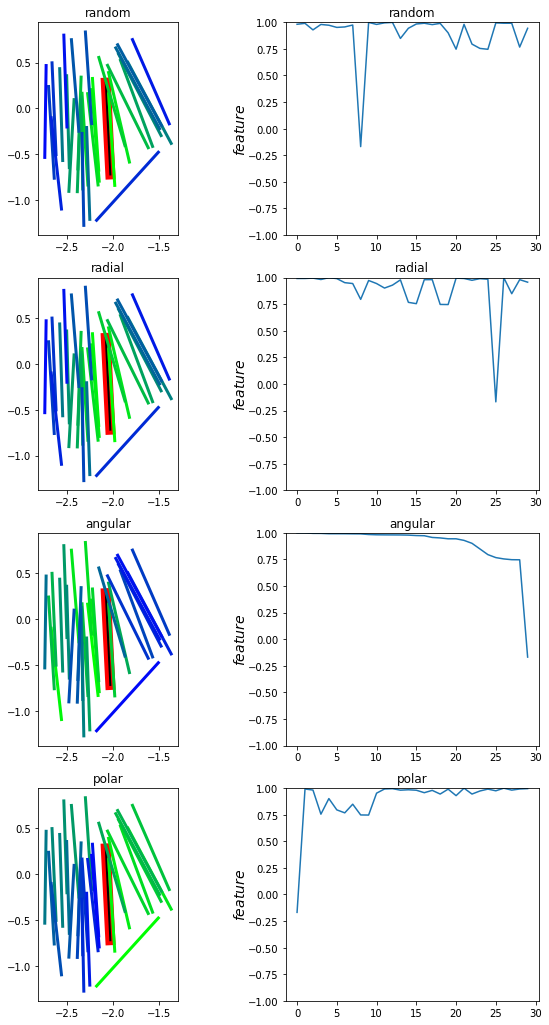

In [34]:
f,ax = plt.subplots(4,2,figsize=(10,18))

irod = 200

for imeth, meth in enumerate(methods):
    ax[imeth,0].set_aspect("equal")
#     plotrods(rods,ax[imeth,0])
    plotrods([rods[irod]],ax[imeth,0],col="r",lw=10.)
    plotrods([rods[irod]],ax[imeth,0],col="k",lw=2.)

    nbrs = nbrs_full[imeth,irod]
    for ni, nbr in enumerate(nbrs[:,:3]):
        col = (0,1-float(ni)/n_nbr,float(ni)/n_nbr)
        plotrods([nbr],ax[imeth,0],col=col,lw=3.)

    ax[imeth,0].set_title(meth)
    ax[imeth,1].set_title(meth)
    ax[imeth,1].set_ylabel(r'$feature$',rotation="vertical",labelpad=0,fontsize=14)
    ax[imeth,1].plot(nbrs[:,3])
    ax[imeth,1].set_ylim(-1,1)
#     break